
# Autonomous Activity: Classical ML Pipeline on Embryo Timelapse

**Dataset:** Six time-lapse `.tif` stacks — **2 controls** and **4 mutants**  
**Biological types:**
- **control**: `Control1`, `Control2`
- **mutantA**: `Mutant1`, `Mutant3`
- **mutantB**: `Mutant2`, `Mutant4`

📁 **Dataset:** [Google Drive Link](https://drive.google.com/drive/folders/1_qxqm-v5yCrme3pAW2rjyOOXIeQDuV54?usp=drive_link)

You will build a complete classical ML pipeline using **per-frame image features**.

## Learning goals
1. **Regression** — predict developmental time (frame index).  
2. **Classification** — (a) 6-class embryo ID, (b) 3-class biological type.  
3. **Clustering** — explore structures and compare with biological types.  
4. **Dimensionality Reduction** — PCA, t‑SNE, UMAP; plot per-embryo **trajectories**.  
5. **Cross‑Validation** — use GroupKFold to avoid leakage across embryos.  
6. **Bias–Variance** — analyze learning and validation curves.

> **No leakage rule:** never mix frames of the **same embryo** across train and test folds.


## Group 5: Jhon Villacis, Jorge Pico


## 0) Environment setup

**Task:** Install the required packages and verify imports.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tifffile
import os
# import plotly.express as px

from skimage import measure, filters, feature, morphology
from scipy.stats import skew, kurtosis, entropy
from skimage.measure import regionprops
from skimage.feature import graycomatrix, graycoprops
import cv2

from sklearn.model_selection import train_test_split, KFold, GroupKFold, cross_val_score, GridSearchCV, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, silhouette_score, make_scorer
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from sklearn.tree import DecisionTreeClassifier


# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Libraries imported.')


Libraries imported.



## 1) Download the 6 TIFF stacks

**Task:** Place your files under a local `data/` folder with the exact names below.  
If using Colab, you may download the shared folder with `gdown`:

- `data/Control1.tif`
- `data/Control2.tif`
- `data/Mutant1.tif`   *(mutantA)*
- `data/Mutant2.tif`   *(mutantB)*
- `data/Mutant3.tif`   *(mutantA)*
- `data/Mutant4.tif`   *(mutantB)*


In [2]:
data = 'data/'


## 2) Load data and define labels

**Task:**
1. Confirm each `.tif` is a stack of shape `(T, H, W)`.
2. Build a tidy `DataFrame` with **one row per frame** and the columns:
   - `embryo_id` ∈ {Control1, Control2, Mutant1, Mutant2, Mutant3, Mutant4}
   - `type3` ∈ {`control`, `mutantA`, `mutantB`}
   - `frame` ∈ {0..T-1}
   - Per-frame features (computed in the next cell)
3. Print basic counts by `embryo_id` and `type3`.


In [3]:
# 1.
image = tifffile.imread('data/'+'Control1.tif')
image.shape

(450, 200, 200)

In [4]:
col1 = []
col2 = []
col3 = []
col4 = []
for i in os.listdir(data):
    image = tifffile.imread(data+i)
    for j, slice_data in enumerate(image):
        col1.append(slice_data)  # Frame data
        col2.append(i[:-4])  # ID
        # type 3
        if 'l' in i:
            col3.append('control')  
        elif 't1' in i or 't3' in i:
            col3.append('mutantA')
        else:
            col3.append('mutantB')
        col4.append(j)  # The actual slice data

dic_data = {
    'image': col1,
    'embryo_id': col2,
    'type3': col3,
    'frame': col4
}

df = pd.DataFrame(dic_data)
df

,image,embryo_id,type3,frame
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant2,mutantB,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant2,mutantB,1
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant2,mutantB,2
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant2,mutantB,3
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant2,mutantB,4
...,...,...,...,...
2695,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant4,mutantB,445
2696,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant4,mutantB,446
2697,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant4,mutantB,447
2698,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant4,mutantB,448


embryo_id
Mutant2     450
Control1    450
Mutant3     450
Control2    450
Mutant1     450
Mutant4     450
Name: count, dtype: int64


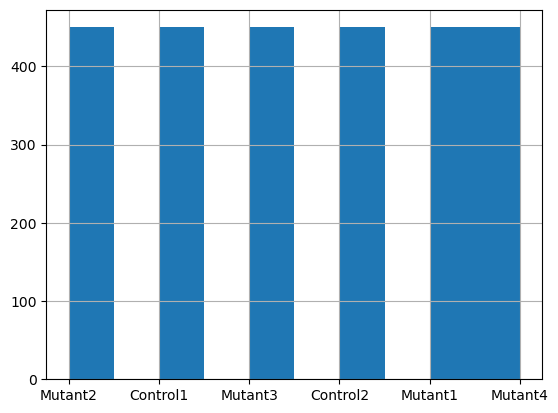

type3
mutantB    900
control    900
mutantA    900
Name: count, dtype: int64


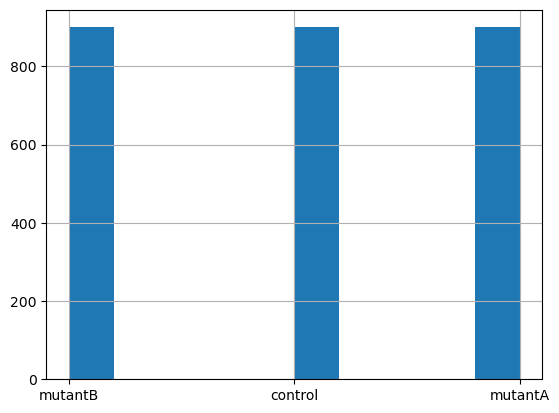

In [5]:
#3
print(df['embryo_id'].value_counts())
df['embryo_id'].hist()
plt.show()
print(df['type3'].value_counts())
df['type3'].hist()
plt.show()

## 2.1) Feature extraction from 2D images

**Task:**

For each  image (or segmented region), compute a set of features for classification.

Suggested features to include in feature_cols :

- Shape-based (geometry): area, perimeter, eccentricity, aspect_ratio, solidity, orientation, extent, compactness. They shoudl be calculted in the segmented object (matrix values lerger than 0)

- Intensity-based:  mean_intensity, std_intensity, min_intensity, max_intensity, skewness, kurtosis

- Texture-based: contrast, correlation, homogeneity, energy, entropy

- Frequency or invariant descriptors : fft_energy, zernike_moments, hu_moments

In [6]:
def extract_features(img):
    # Ensure image is float
    img = img.astype(float)
    
    # --- Segmentation mask ---
    mask = img > 0  # segmented object (nonzero pixels)

    # --- Shape-based features ---
    props = regionprops(mask.astype(int))
    if len(props) == 0:
        return {k: np.nan for k in [
            'area','perimeter','eccentricity','aspect_ratio','solidity',
            'orientation','extent','compactness',
            'mean_intensity','std_intensity','min_intensity','max_intensity',
            'skewness','kurtosis','contrast','correlation','homogeneity',
            'energy','entropy','fft_energy','hu_moments'
        ]} # ,'zernike_moments','hu_moments']}

    p = props[0]
    shape_feats = {
        'area': p.area,
        'perimeter': p.perimeter,
        'eccentricity': p.eccentricity,
        'aspect_ratio': p.minor_axis_length / p.major_axis_length if p.major_axis_length != 0 else np.nan,
        'solidity': p.solidity,
        'orientation': p.orientation,
        'extent': p.extent,
        'compactness': (4 * np.pi * p.area) / (p.perimeter ** 2) if p.perimeter != 0 else np.nan
    }

    # --- Intensity-based features ---
    vals = img[mask]
    intensity_feats = {
        'mean_intensity': vals.mean(),
        'std_intensity': vals.std(),
        'min_intensity': vals.min(),
        'max_intensity': vals.max(),
        'skewness': skew(vals),
        'kurtosis': kurtosis(vals)
    }

    # --- Texture-based features (GLCM) ---
    img8 = (255 * (img - img.min()) / (img.max() - img.min() + 1e-8)).astype(np.uint8)
    glcm = graycomatrix(img8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    texture_feats = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'entropy': entropy(glcm.ravel())
    }

    # --- Frequency / invariant features ---
    # FFT energy
    fft = np.fft.fft2(img)
    fft_energy = np.sum(np.abs(fft) ** 2) / img.size

    # Hu Moments
    moments = cv2.moments(img)
    hu = cv2.HuMoments(moments).flatten()
    
    # Zernike moments (requires circular mask)
    radius = min(img.shape) // 2
    circle_mask = morphology.disk(radius)
    # zernike = measure.zernike_moments(img, radius=radius, degree=8)

    freq_feats = {
        'fft_energy': fft_energy,
        # 'zernike_moments': np.mean(np.abs(zernike)),
        'hu_moments': np.mean(np.abs(hu))
    }

    # Combine all
    feats = {**shape_feats, **intensity_feats, **texture_feats, **freq_feats}
    return feats


# --- Apply to DataFrame ---
feature_dicts = df['image'].apply(extract_features)
feature_df = pd.DataFrame(list(feature_dicts))
df = pd.concat([df, feature_df], axis=1)

In [7]:
df

,image,embryo_id,type3,frame,area,perimeter,eccentricity,aspect_ratio,solidity,orientation,...,max_intensity,skewness,kurtosis,contrast,correlation,homogeneity,energy,entropy,fft_energy,hu_moments
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant2,mutantB,0,10367.0,391.546248,0.402598,0.915377,0.978203,0.625821,...,208.0,-0.760623,-0.337507,88.227889,0.991677,0.780735,0.736478,2.729346,182656670.0,0.000160
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant2,mutantB,1,10444.0,395.546248,0.397391,0.917649,0.978361,0.642810,...,202.0,-0.754127,-0.392741,91.017940,0.991956,0.779425,0.734494,2.743582,184047092.0,0.000160
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant2,mutantB,2,10490.0,392.475180,0.408817,0.912617,0.979824,0.630153,...,203.0,-0.785309,-0.380715,83.251759,0.992801,0.780014,0.733389,2.744756,190209065.0,0.000157
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant2,mutantB,3,10606.0,395.060967,0.421556,0.906802,0.979136,0.636865,...,207.0,-0.813871,-0.345293,86.721859,0.992444,0.777423,0.730450,2.773340,196930648.0,0.000155
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant2,mutantB,4,10679.0,400.475180,0.449878,0.893090,0.979815,0.661290,...,208.0,-0.810481,-0.315412,90.732462,0.992269,0.776628,0.728616,2.793075,203831611.0,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant4,mutantB,445,11981.0,441.931024,0.635399,0.772184,0.973037,-1.149297,...,204.0,-0.343321,-0.511909,66.623467,0.992594,0.747220,0.695804,3.130811,155794877.0,0.000201
2696,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant4,mutantB,446,12089.0,446.859956,0.638145,0.769916,0.967817,-1.182643,...,205.0,-0.364763,-0.478971,87.793970,0.990254,0.743181,0.693090,3.165113,157988524.0,0.000204
2697,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant4,mutantB,447,12155.0,449.345238,0.642257,0.766490,0.967062,-1.170675,...,205.0,-0.356988,-0.490628,86.223819,0.990493,0.743062,0.691457,3.180983,159472622.0,0.000204
2698,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mutant4,mutantB,448,11899.0,437.830519,0.633772,0.773520,0.971982,-1.187959,...,207.0,-0.335166,-0.508101,66.983869,0.992267,0.750731,0.697813,3.111487,153803053.0,0.000202


In [8]:
print(df.isna().sum())

image             0
embryo_id         0
type3             0
frame             0
area              2
perimeter         2
eccentricity      2
aspect_ratio      2
solidity          2
orientation       2
extent            2
compactness       2
mean_intensity    2
std_intensity     2
min_intensity     2
max_intensity     2
skewness          2
kurtosis          2
contrast          2
correlation       2
homogeneity       2
energy            2
entropy           2
fft_energy        2
hu_moments        2
dtype: int64


In [9]:
df.dropna(inplace=True)
print(df.isna().sum())

image             0
embryo_id         0
type3             0
frame             0
area              0
perimeter         0
eccentricity      0
aspect_ratio      0
solidity          0
orientation       0
extent            0
compactness       0
mean_intensity    0
std_intensity     0
min_intensity     0
max_intensity     0
skewness          0
kurtosis          0
contrast          0
correlation       0
homogeneity       0
energy            0
entropy           0
fft_energy        0
hu_moments        0
dtype: int64


In [10]:
df.reset_index(inplace=True)


## 2.2) Feature matrix and grouping (anti-leakage)

**Task:**
- Select `feature_cols` (use at least the ones built above).
- Build:  
  `X` (features), `y_reg = frame`, `y_id6 = embryo_id`, `y_type3 = type3`  
- Define `groups = embryo_id` to be used in GroupKFold.


In [11]:
X = df.drop(columns=['image', 'embryo_id', 'type3', 'frame'], axis=1)
y_reg = df['frame']
y_id6 = df['embryo_id']
y_type3 = df['type3']

groups = df['embryo_id']


## 3) Supervised Learning — Regression (frame index)

**Task :**
1. Implement 3 models using `Pipeline`:
   - `LinearRegression` (+ `StandardScaler`)
   - `Ridge(alpha)` — try `alpha ∈ {0.1, 1, 10}`
   - `KNeighborsRegressor` — try `n_neighbors ∈ {3,5,7,11}` with `MinMaxScaler`
2. Use **GroupKFold** with `n_splits = min(6, #embryos)` to evaluate **MAE** and **R²**.
3. Report mean metrics for each model and **compare**.
4. Plot **True vs Predicted** for one representative split.



=== Model Comparison ===
              Model    MAE_mean    MAE_std   R2_mean    R2_std
7          KNN_k=11  108.139254  29.492245 -0.390159  0.701117
6           KNN_k=7  109.968929  29.761508 -0.454825  0.736263
5           KNN_k=5  111.488060  30.902588 -0.498736  0.765766
4           KNN_k=3  113.594451  31.553214 -0.559577  0.774407
0  LinearRegression  156.027332  72.670335 -1.684272  2.251852
1   Ridge_alpha=0.1  162.372356  72.014960 -1.826383  2.339981
2     Ridge_alpha=1  162.566000  72.010542 -1.814650  2.385599
3    Ridge_alpha=10  163.202567  79.907043 -1.833014  2.656131


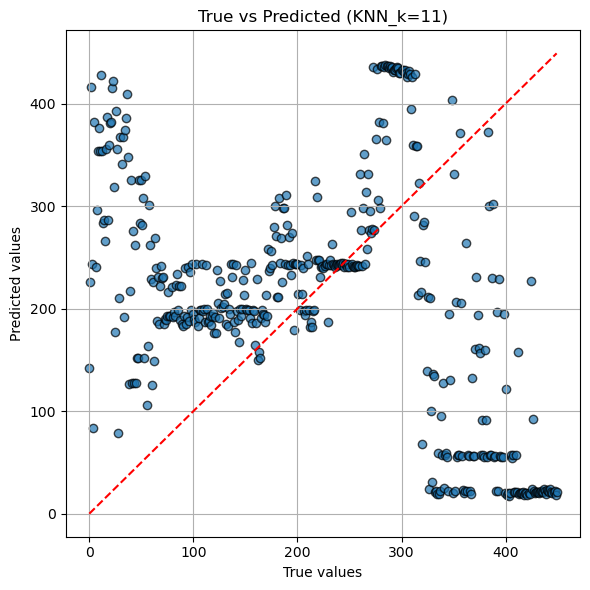

In [12]:
y = y_reg  # regression target

# -------------------------------
# 1. Define models and hyperparams
# -------------------------------
models = {
    'LinearRegression': Pipeline([('scaler', StandardScaler()),('model', LinearRegression()) ]),
    **{f'Ridge_alpha={a}': Pipeline([('scaler', StandardScaler()),('model', Ridge(alpha=a))]) for a in [0.1, 1, 10]},
    **{f'KNN_k={k}': Pipeline([('scaler', MinMaxScaler()),('model', KNeighborsRegressor(n_neighbors=k))]) for k in [3, 5, 7, 11]}
}

# -------------------------------
# 2. Define models and hyperparams
# -------------------------------

n_splits = min(6, groups.nunique())
gkf = GroupKFold(n_splits=n_splits)


# ---------------------------------------------------
# Run GroupKFold evaluation
# ---------------------------------------------------
results = []
fold_predictions = {}

for name, pipe in models.items():
    mae_scores = []
    r2_scores = []

    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mae_scores.append(mae)
        r2_scores.append(r2)

        # Save one fold’s predictions for plotting
        if fold == 0:
            fold_predictions[name] = (y_test, y_pred)

    results.append({
        'Model': name,
        'MAE_mean': np.mean(mae_scores),
        'MAE_std': np.std(mae_scores),
        'R2_mean': np.mean(r2_scores),
        'R2_std': np.std(r2_scores)
    })

# ---------------------------------------------------
# Results summary
# ---------------------------------------------------
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df.sort_values(by='MAE_mean'))

# ---------------------------------------------------
# Plot True vs Predicted for one representative split
# ---------------------------------------------------
rep_model = results_df.loc[results_df['MAE_mean'].idxmin()]['Model']

# Alternatively, choose manually:
# rep_model = 'Ridge_1'

y_test, y_pred = fold_predictions[rep_model]

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title(f'True vs Predicted ({rep_model})')
plt.grid(True)
plt.tight_layout()
plt.show()


## 4) Supervised Learning — Classification

Two tasks (do **both**):
- **ID-6:** predict `embryo_id` (6 classes)
- **Type-3:** predict `type3` (3 classes: control, mutantA, mutantB)

**Task:**
1. Implement 3 classifiers with `Pipeline`:
   - `LogisticRegression(max_iter=1000)`
   - `KNeighborsClassifier`
   - `SVC(kernel='rbf')`
2. Evaluate with **GroupKFold**. Metrics: **Accuracy** and **F1‑macro**.
3. Compare **ID-6** vs **Type-3** (expect Type-3 to be easier).
4. Add confusion matrices.



=== Type3 Classification Comparison ===
                Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std
2                 SVC       0.314669      0.356925  0.123891  0.132549
1                 KNN       0.253338      0.355082  0.119179  0.162586
0  LogisticRegression       0.296296      0.421425  0.104375  0.147848


<Figure size 500x400 with 0 Axes>

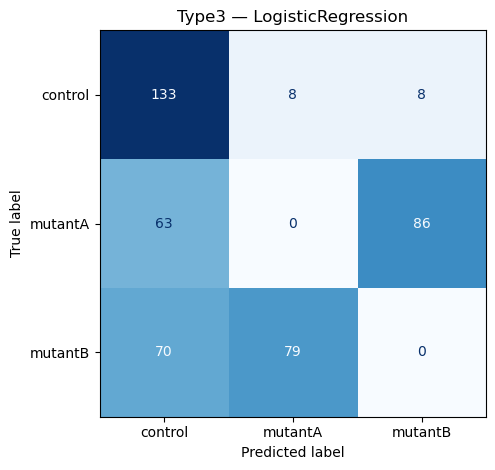

<Figure size 500x400 with 0 Axes>

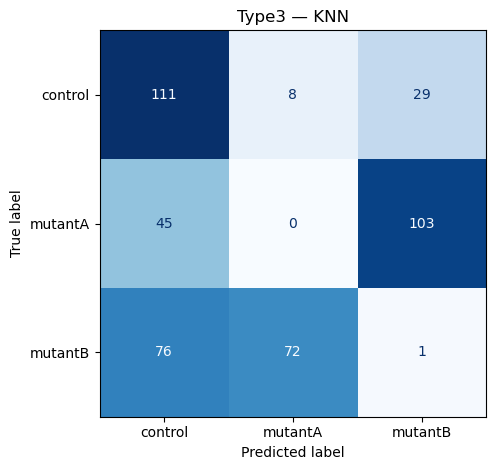

<Figure size 500x400 with 0 Axes>

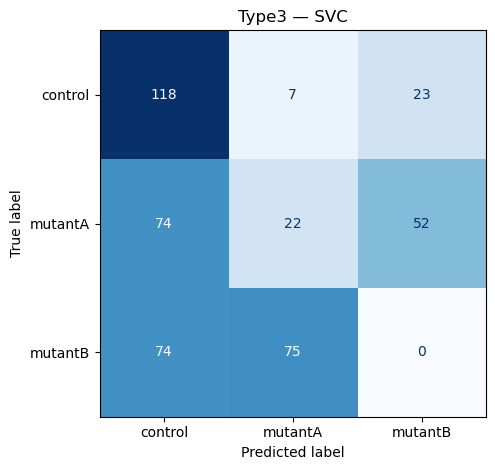

In [13]:
y = y_type3  # clsification target

# Ensure we know all classes
all_classes = np.unique(y)

# --------------------------------------------------
# Define classifiers in pipelines
# --------------------------------------------------
models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier(n_neighbors=5))
    ]),
    'SVC': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(kernel='rbf', probability=True))
    ])
}

# --------------------------------------------------
# GroupKFold setup
# --------------------------------------------------
gkf = GroupKFold(n_splits=len(np.unique(groups)))

# --------------------------------------------------
# Evaluate classifiers
# --------------------------------------------------
results = []
conf_matrices = {}

for model_name, pipe in models.items():
    acc_scores = []
    f1_scores = []
    conf_temp = [] 

    # Use first fold for confusion matrix
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))

        conf_temp.append(confusion_matrix(y_test, y_pred, labels=all_classes))
        # # Save confusion matrix for the first fold only
        # if fold == 0:
        #     # Force all classes to appear in the matrix
        #     cm = confusion_matrix(y_test, y_pred, labels=all_classes)
        #     conf_matrices[model_name] = cm
    
    # Average confusion matrices over folds
    avg_cm = np.mean(conf_temp, axis=0).astype(int)
    conf_matrices[model_name] = avg_cm

    results.append({
        'Model': model_name,
        'Accuracy_mean': np.mean(acc_scores),
        'Accuracy_std': np.std(acc_scores),
        'F1_mean': np.mean(f1_scores),
        'F1_std': np.std(f1_scores)
    })

# --------------------------------------------------
# Display results
# --------------------------------------------------
results_df = pd.DataFrame(results)
print("\n=== Type3 Classification Comparison ===")
print(results_df.sort_values(by='F1_mean', ascending=False))

# --------------------------------------------------
# Plot confusion matrices
# --------------------------------------------------
for model_name, cm in conf_matrices.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
    plt.figure(figsize=(5, 4))
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    plt.title(f"Type3 — {model_name}")
    plt.tight_layout()
    plt.show()



=== Type3 Classification Comparison ===
                Model  Accuracy_mean  Accuracy_std  F1_mean  F1_std
0  LogisticRegression            0.0           0.0      0.0     0.0
1                 KNN            0.0           0.0      0.0     0.0
2                 SVC            0.0           0.0      0.0     0.0


<Figure size 500x400 with 0 Axes>

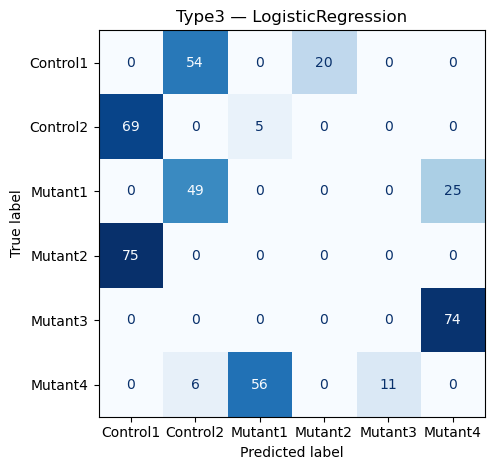

<Figure size 500x400 with 0 Axes>

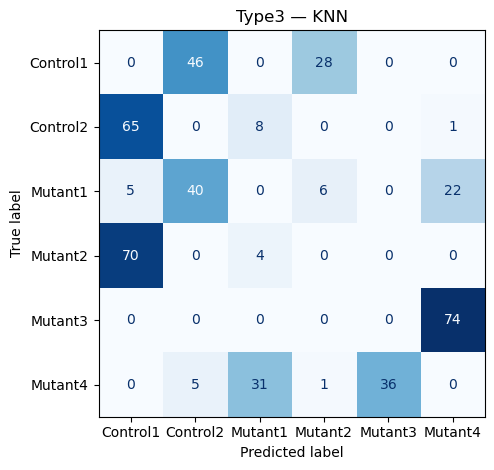

<Figure size 500x400 with 0 Axes>

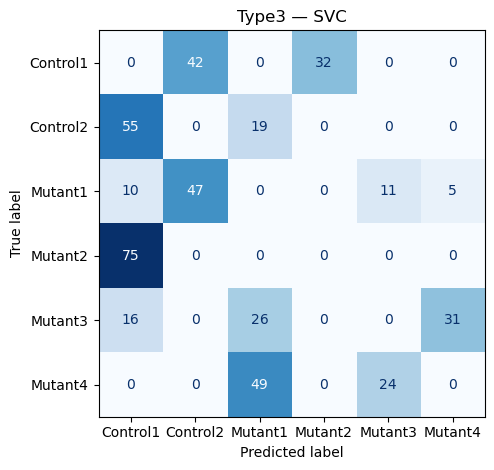

In [14]:
y = y_id6  # clsification target

# Ensure we know all classes
all_classes = np.unique(y)

# --------------------------------------------------
# Define classifiers in pipelines
# --------------------------------------------------
models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier(n_neighbors=5))
    ]),
    'SVC': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(kernel='rbf', probability=True))
    ])
}

# --------------------------------------------------
# GroupKFold setup
# --------------------------------------------------
gkf = GroupKFold(n_splits=len(np.unique(groups)))

# --------------------------------------------------
# Evaluate classifiers
# --------------------------------------------------
results = []
conf_matrices = {}

for model_name, pipe in models.items():
    acc_scores = []
    f1_scores = []
    conf_temp = [] 

    # Use first fold for confusion matrix
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))

        conf_temp.append(confusion_matrix(y_test, y_pred, labels=all_classes))
        # # Save confusion matrix for the first fold only
        # if fold == 0:
        #     # Force all classes to appear in the matrix
        #     cm = confusion_matrix(y_test, y_pred, labels=all_classes)
        #     conf_matrices[model_name] = cm
    
    # Average confusion matrices over folds
    avg_cm = np.mean(conf_temp, axis=0).astype(int)
    conf_matrices[model_name] = avg_cm

    results.append({
        'Model': model_name,
        'Accuracy_mean': np.mean(acc_scores),
        'Accuracy_std': np.std(acc_scores),
        'F1_mean': np.mean(f1_scores),
        'F1_std': np.std(f1_scores)
    })

# --------------------------------------------------
# Display results
# --------------------------------------------------
results_df = pd.DataFrame(results)
print("\n=== Type3 Classification Comparison ===")
print(results_df.sort_values(by='F1_mean', ascending=False))

# --------------------------------------------------
# Plot confusion matrices
# --------------------------------------------------
for model_name, cm in conf_matrices.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
    plt.figure(figsize=(5, 4))
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    plt.title(f"Type3 — {model_name}")
    plt.tight_layout()
    plt.show()


## 5) Unsupervised Learning — Clustering

**Task (no solutions provided):**
1. Standardize `X` with `StandardScaler`.
2. Apply **KMeans** and **AgglomerativeClustering** with:
   - `n_clusters=3` (biological types)
   - (Optional) `n_clusters=6` (embryo IDs)
3. Compute **silhouette score** (unsupervised metric).
4. Build crosstabs: **cluster vs `type3`** and **cluster vs `embryo_id`** (for interpretation only).



=== Clustering Silhouette Scores ===
             Model  Silhouette
2         KMeans_6    0.243136
3  Agglomerative_6    0.211759
0         KMeans_3    0.201735
1  Agglomerative_3    0.163897

--- KMeans_3 ---

Cluster vs type3:
type3    control  mutantA  mutantB
cluster                           
0            443      398      327
1              0      262      121
2            457      238      452

Cluster vs embryo_id:
embryo_id  Control1  Control2  Mutant1  Mutant2  Mutant3  Mutant4
cluster                                                          
0               187       256      180      125      218      202
1                 0         0       85       26      177       95
2               263       194      185      299       53      153

--- Agglomerative_3 ---

Cluster vs type3:
type3    control  mutantA  mutantB
cluster                           
0            610      383      709
1              0      244        0
2            290      271      191

Cluster vs embryo_id:


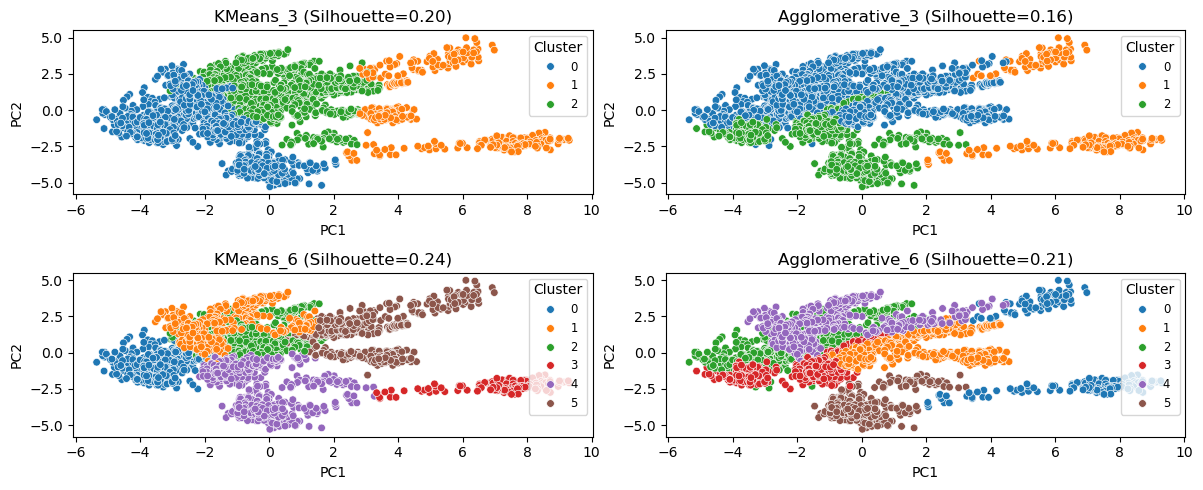

In [15]:
y_embryo = y_id6

# --------------------------------------------------
# Step 1 — Standardize features
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# Step 2 — Define clustering models
# --------------------------------------------------
cluster_settings = {
    'KMeans_3': KMeans(n_clusters=3, random_state=0, n_init=20),
    'Agglomerative_3': AgglomerativeClustering(n_clusters=3),
    'KMeans_6': KMeans(n_clusters=6, random_state=0, n_init=20),
    'Agglomerative_6': AgglomerativeClustering(n_clusters=6)
}

# --------------------------------------------------
# Step 3 — Fit and compute silhouette score
# --------------------------------------------------
results = []
cluster_labels = {}

for name, model in cluster_settings.items():
    labels = model.fit_predict(X_scaled)
    cluster_labels[name] = labels

    score = silhouette_score(X_scaled, labels)
    results.append({'Model': name, 'Silhouette': score})

results_df = pd.DataFrame(results)
print("\n=== Clustering Silhouette Scores ===")
print(results_df.sort_values(by='Silhouette', ascending=False))

# --------------------------------------------------
# Step 4 — Crosstabs for interpretation
# --------------------------------------------------
for name, labels in cluster_labels.items():
    print(f"\n--- {name} ---")
    df_temp = pd.DataFrame({
        'cluster': labels,
        'type3': y_type3.values,
        'embryo_id': y_embryo.values
    })

    print("\nCluster vs type3:")
    print(pd.crosstab(df_temp['cluster'], df_temp['type3']))

    print("\nCluster vs embryo_id:")
    print(pd.crosstab(df_temp['cluster'], df_temp['embryo_id']))

# --------------------------------------------------
# Optional — visualize clusters in 2D using PCA
# --------------------------------------------------
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))
for i, (name, labels) in enumerate(cluster_labels.items(), 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10', s=30)
    plt.title(f"{name} (Silhouette={results_df.loc[results_df.Model == name, 'Silhouette'].values[0]:.2f})")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster', loc='best', fontsize='small')
plt.tight_layout()
plt.show()



## 6) Dimensionality Reduction + Trajectories

**Task :**
1. Compute **PCA(2)**, **t‑SNE(2)**, and **UMAP(2)** on standardized `X`.
2. Scatter-plot colored by `type3` (optionally also by `embryo_id`).
3. **Trajectories:** for each `embryo_id`, sort by `frame` and **connect** points in 2D.
4. Comment on which embedding separates **types** more clearly and which trajectories look smoother or diverge.


/home/deck/anaconda3/envs/DA_ML/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


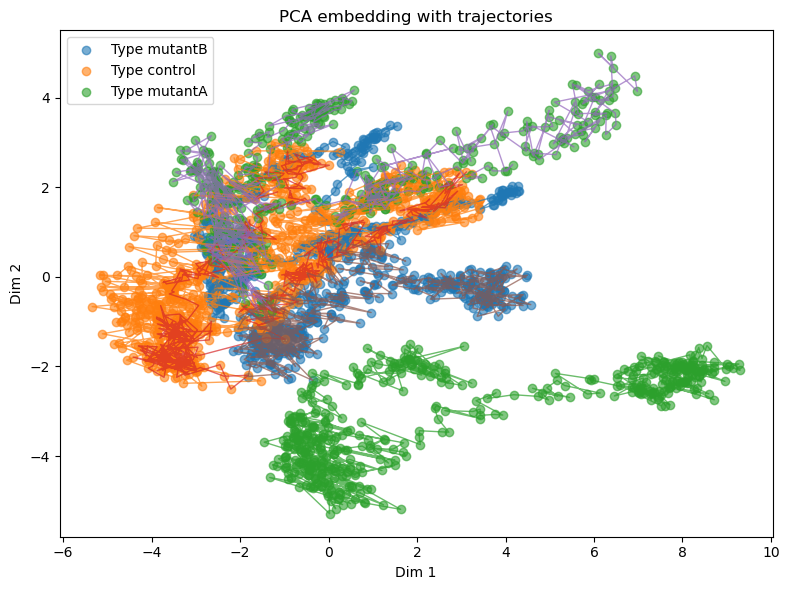

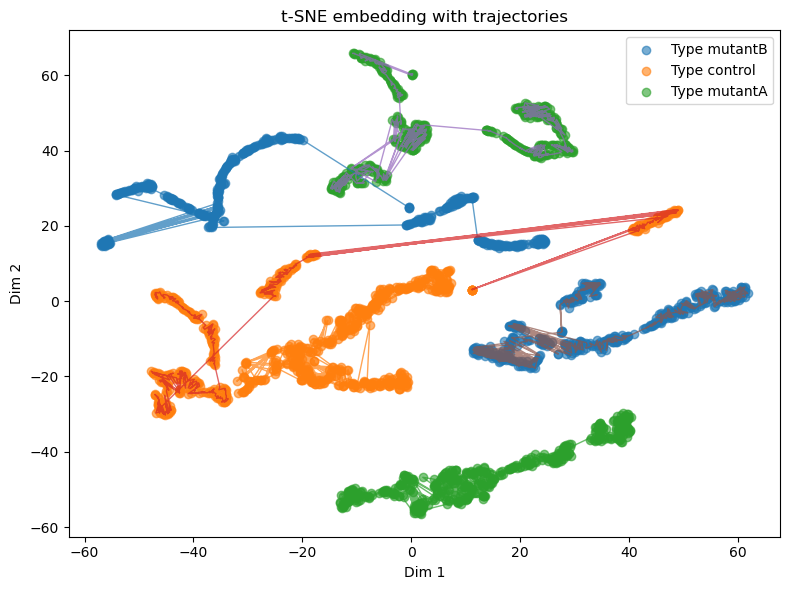

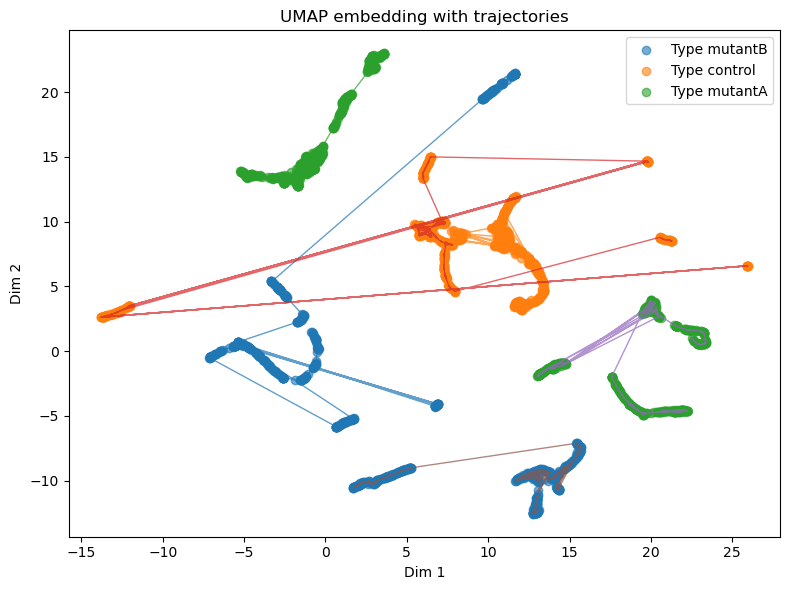

In [16]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Compute embeddings
pca_2d = PCA(n_components=2).fit_transform(X_scaled)
tsne_2d = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(X_scaled)

embeddings = {
    'PCA': pca_2d,
    't-SNE': tsne_2d,
    'UMAP': umap_2d
}

# 2. Scatter plots with trajectories
for name, emb in embeddings.items():
    plt.figure(figsize=(8,6))
    
    # Scatter colored by type3
    types = df['type3'].unique()
    for t in types:
        mask = df['type3'] == t
        plt.scatter(emb[mask,0], emb[mask,1], label=f'Type {t}', alpha=0.6)
    
    # 3. Add trajectories by embryo_id
    for eid in df['embryo_id'].unique():
        traj = df[df['embryo_id']==eid].sort_values('frame')
        plt.plot(emb[traj.index, 0], emb[traj.index, 1], linewidth=1, alpha=0.7)
    
    plt.title(f'{name} embedding with trajectories')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.legend()
    plt.tight_layout()
    plt.show()



## 7) Cross‑Validation without leakage vs naïve split

**Task :**
1. Use **GroupKFold** (groups = `embryo_id`) with `LogisticRegression` for the **Type-3** task.
2. Compare against a naïve frame-wise `train_test_split` (this leaks information).
3. Report **Accuracy** and **F1‑macro** for both; discuss overestimation from leakage.


In [17]:
y = y_type3  # clsification target

# Ensure we know all classes
all_classes = np.unique(y)

# --------------------------------------------------
# Define classifiers in pipelines
# --------------------------------------------------
LogRegPipe = Pipeline([('scaler', StandardScaler()),('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])

results = []

# --------------------------------------------------
# GroupKFold setup****************************************************************************************************************
# --------------------------------------------------
gkf = GroupKFold(n_splits=len(np.unique(groups)))

acc_scores = []
f1_scores = []

for train_idx, test_idx in gkf.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    LogRegPipe.fit(X_train, y_train)
    y_pred = LogRegPipe.predict(X_test)

    acc_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))


results.append({
    'Model': 'GroupKFold',
    'Accuracy_mean': np.mean(acc_scores),
    'Accuracy_std': np.std(acc_scores),
    'F1_mean': np.mean(f1_scores),
    'F1_std': np.std(f1_scores)
})

# --------------------------------------------------
# Naive split setup****************************************************************************************************************
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

LogRegPipe.fit(X_train, y_train)
y_pred = LogRegPipe.predict(X_test)

acc_scores = accuracy_score(y_test, y_pred)
f1_scores = f1_score(y_test, y_pred, average='macro')

results.append({
    'Model': 'NaiveSplit',
    'Accuracy_mean': np.mean(acc_scores),
    'Accuracy_std': np.std(acc_scores),
    'F1_mean': np.mean(f1_scores),
    'F1_std': np.std(f1_scores)
})

# --------------------------------------------------
# Display results
# --------------------------------------------------
results_df = pd.DataFrame(results)
print("\n=== Type3 Classification with logistic regression Comparison ===")
print(results_df.sort_values(by='F1_mean', ascending=False))



=== Type3 Classification with logistic regression Comparison ===
        Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std
1  NaiveSplit       0.992593      0.000000  0.992540  0.000000
0  GroupKFold       0.296296      0.421425  0.104375  0.147848



## 8) Bias–Variance and Overfitting

**Task (no solutions provided):**
1. Choose `DecisionTreeClassifier` or `KNN` for the **Type-3** task.
2. **Learning curve:** use `learning_curve` with GroupKFold. Plot training size vs Accuracy (train vs validation).
3. **Validation curve:** plot hyperparameter vs Accuracy (e.g., `max_depth` for a tree, or `n_neighbors` for KNN).
4. Conclude: identify **high variance** (train ≫ val) or **high bias** (both low) and propose tuning (regularization, features, data, hyperparameters).


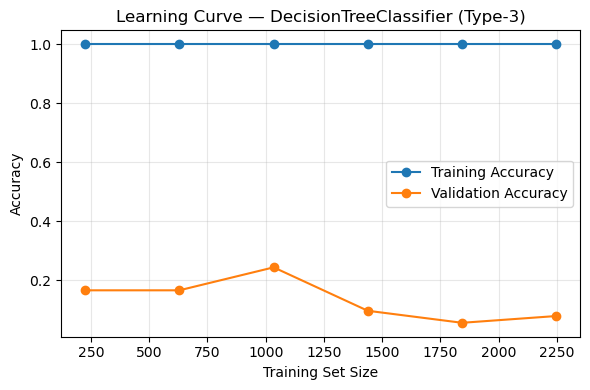

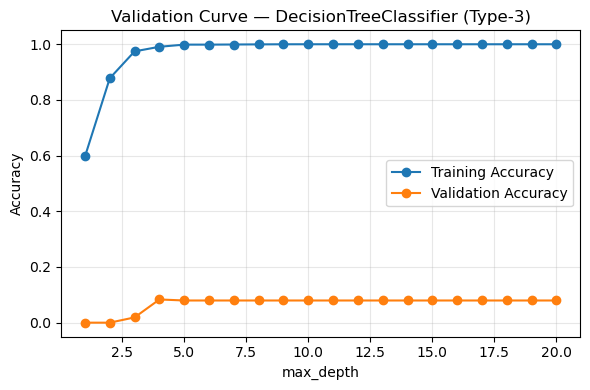

In [18]:
y = y_type3  # classification target

# Standardize + Decision Tree
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier(random_state=42))
])

# --------------------------------------------------
# Cross-validation config
# --------------------------------------------------
n_splits = min(6, len(np.unique(groups)))
gkf = GroupKFold(n_splits=n_splits)

# --------------------------------------------------
# Learning curve — train size vs performance
# --------------------------------------------------
train_sizes, train_scores, val_scores = learning_curve(
    pipe,
    X, y,
    groups=groups,
    cv=gkf,
    scoring=make_scorer(accuracy_score),
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve — DecisionTreeClassifier (Type-3)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Validation curve — hyperparameter vs performance
# --------------------------------------------------
param_range = np.arange(1, 21)  # max_depth range

train_scores, val_scores = validation_curve(
    pipe,
    X, y,
    param_name='model__max_depth',
    param_range=param_range,
    groups=groups,
    cv=gkf,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(param_range, train_mean, 'o-', label='Training Accuracy')
plt.plot(param_range, val_mean, 'o-', label='Validation Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve — DecisionTreeClassifier (Type-3)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## 9) Deliverables

1. **Regression (frame):** best model + settings. Report GroupKFold **MAE** and **R²**; include a True vs Predicted plot.  
2. **Classification:** compare **ID-6** vs **Type-3**. Which models worked best? Include **Accuracy** and **F1‑macro**.  
3. **Clustering:** does `k=3` reveal types? How does `k=6` behave? Report silhouette and discuss crosstabs.  
4. **Dimensionality reduction:** which embedding separates **types** best? Show trajectories by `embryo_id` and discuss.  
5. **Cross‑Validation:** quantify overestimation from naïve split vs GroupKFold.  
6. **Bias–Variance:** interpret curves and propose next steps (regularization, features, data, hyperparameters).  

